In [9]:
%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, t, kstest
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import random
np.random.seed(0)


In [10]:

n = 500
p = 10
iters = 10000
lam = 0.1
true_beta = np.zeros(p)  
std_noise = 10

X = np.random.normal(0, 1, size=(n, p))

In [ ]:


def create_data(X, true_beta, intercept = 0, std_noise = 1):
    n = X.shape[0]
    linear_component = X @ true_beta
    noise = np.random.normal(0, std_noise, size = n)
    y = linear_component + noise + intercept
    return y


def fit_lasso_model_sklearn(X, y, lam):
    model = Lasso(alpha=lam, fit_intercept=True, tol=1e-4, max_iter=2000)
    model.fit(X, y)
    return model.coef_, model.intercept_

def fit_lasso_model(X, y, lam, max_iter = 7000, tol = 1e-5):
    def soft_thresolding(rho, lam, z):
        if rho < -lam:
            return (rho + lam)/z
        elif rho > lam:
            return (rho - lam)/z
        else:
            return 0
    n, p = X.shape
    beta = np.zeros(p)
    # residual = y - X @ beta
    intercept = np.mean(y)
    for iter in range(max_iter):
        beta_old = beta.copy()
        intercept_old = intercept

        intercept = np.mean(y - X @ beta)
        for j in range(p):
            r_j = y - X @ beta + X[:, j] * beta[j] - intercept
            rho = 1/n * X[:, j].T @ r_j
            z = 1/n * (X[:, j] ** 2).sum()

            beta[j] = soft_thresolding(rho, lam, z)
            residual = r_j - X[:, j] * beta[j]
        if np.linalg.norm(beta - beta_old, ord=1) < tol and abs(intercept - intercept_old) < tol:
            break
        # intercept = np.mean(y) - np.sum(np.mean(X, axis = 0) * beta) 
    return beta, intercept

def calculating_p_value(X, active_set, y, beta_hat, intercept, std_noise, lam):
    n, p = X.shape
    X_active = X[:, active_set]
    beta_hat_active = beta_hat[active_set]
    p_active = len(active_set)
    s = np.sign(beta_hat_active)   
    choice = random.randint(0, p_active - 1)
    e_j = np.zeros(p_active)
    e_j[choice] = 1 
    # etaT = e_j.T @ np.linalg.inv(X_active.T @ X_active) @ X_active.T 
    X_plus = np.linalg.inv(X_active.T @ X_active) @ X_active.T
    eta = (X_plus.T @ e_j).reshape(-1, 1)
    covariance_matrix = np.diag([std_noise ** 2] * n) #Too lazy to calculate this
    identity_n = np.identity(n)
    

    projection_matrix = X_active @ np.linalg.inv(X_active.T @ X_active) @ X_active.T
    non_active_set = np.setdiff1d(np.arange(p), active_set)
    X_nonactive = X[:, non_active_set]
    
    A_0_helper = X_nonactive.T @ (identity_n - projection_matrix)
    A_0 = 1/ lam * np.vstack([A_0_helper, - A_0_helper])

    b_0_helper = (X_nonactive.T @ X_plus.T @ s).reshape(-1, 1)
    b_0 = np.vstack([1 - b_0_helper, 1 + b_0_helper])
    A_1 = -np.diag(s) @ X_plus
    b_1 = (- lam * np.diag(s) @ np.linalg.inv(X_active.T @ X_active) @ s).reshape(-1, 1)
    # print(X_plus.shape, projection_matrix.shape, A_0.shape, A_1.shape, b_0.shape, b_1.shape, b_0_helper.shape, covariance_matrix.shape, eta.shape)
    A = np.vstack([A_0, A_1])
    b = np.vstack([b_0, b_1])

    c = covariance_matrix @ eta @ np.linalg.inv( eta.T @ covariance_matrix @ eta)
    z = (identity_n - eta.T @ c) @ y
    
    Az = A @ z
    Ac = A @ c
    #define boundary V_-, V_+, V_0
    vminus = float('-inf')
    vplus = float('inf')
    v_0 = float('inf')
    for idx in range(A.shape[0]):
        if Ac[idx] > 0 and (b[idx] - Az[idx]) / Ac[idx] < vplus:
            vplus = (b[idx] - Az[idx]) / Ac[idx]
        elif Ac[idx] < 0 and (b[idx] - Az[idx]) / Ac[idx] > vminus:
            vminus = (b[idx] - Az[idx]) / Ac[idx]
        elif Ac[idx] == 0 and b[idx] - Az[idx] < v_0:
            v_0 = b[idx] - Az[idx]
    if v_0 == 0:
        return 0
    else:
        return 2 * min(1 - f(0, std_noise, vminus, vplus, beta_hat[choice]), f(0, std_noise, vminus, vplus, beta_hat[choice]))
def f(mu, sigma, a, b, x):
    return (norm.cdf(x, loc = mu, scale = sigma) - norm.cdf(a, loc = mu, scale = sigma)) / (norm.cdf(b, loc = mu, scale = sigma) - norm.cdf(a, loc = mu, scale = sigma))






In [12]:
beta_hat_list = [] 
p_values_lists = []
ran_p_values_list = []
for iter in range(iters):
    y = create_data(X, true_beta, 0, std_noise)
    beta_hat, intercept = fit_lasso_model(X, y, lam)
    
    full_beta = np.concatenate([[intercept], beta_hat])
    beta_hat_list.append(full_beta)

    active_set = np.where(np.abs(beta_hat) > 1e-4)[0]
    p_value = calculating_p_value(X, active_set, y, beta_hat, intercept, std_noise, lam)
    p_values_lists.append(p_value)

C:\Users\Admin\AppData\Local\Temp\ipykernel_22644\955285985.py:93: RuntimeWarning: divide by zero encountered in divide
  return (norm.cdf(x, loc = mu, scale = sigma) - norm.cdf(a, loc = mu, scale = sigma)) / (norm.cdf(b, loc = mu, scale = sigma) - norm.cdf(a, loc = mu, scale = sigma))


In [13]:
# beta_df = pd.DataFrame(beta_hat_list)

# fig, axes = plt.subplots(2, 3, figsize = (15, 10))
# axes = axes.flatten()

# for idx in range(6):
#     axes[idx].hist(beta_df[idx], bins = 30, density = True,edgecolor = 'black')
#     axes[idx].set_title(f'Phân phối của beta{idx}')
#     axes[idx].set_xlabel('beta')
#     axes[idx].set_ylabel('Số lần')
# axes[0].set_title(f'intercept')

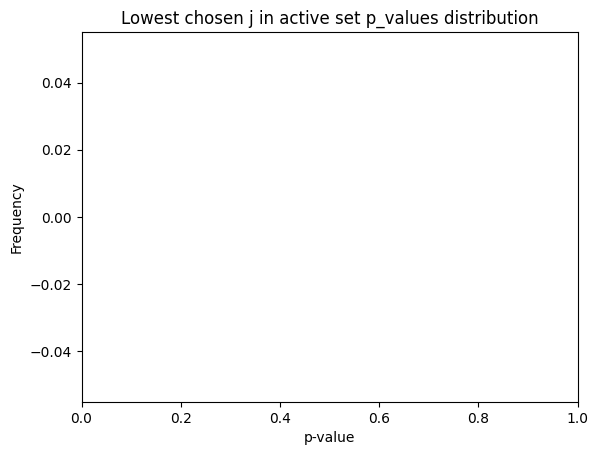

In [14]:


plt.figure()
plt.xlim(0, 1)
plt.hist(ran_p_values_list, bins = 50)
plt.title(f'Lowest chosen j in active set p_values distribution')
plt.xlabel(f'p-value')
plt.ylabel(f'Frequency')

plt.show()


In [15]:
ran_p_values_list = np.array(ran_p_values_list)
print(np.max(ran_p_values_list))
print(len(ran_p_values_list))
print(np.sum(ran_p_values_list > 0.8))
print(np.sum(ran_p_values_list<0.2))

ValueError: zero-size array to reduction operation maximum which has no identity